In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict
from scipy.stats.mstats import gmean
import netCDF4 as nc

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display



%matplotlib inline

In [2]:

data = pd.read_csv('/ocean/ksuchy/MOAD/analysis-karyn/notebooks/SalishSea_MicrozoopModelvsObsMatches_2015to2019_Eval202111.csv', index_col=0,header=0)

In [3]:
print(data['Total'].min())
print(data['Total'].max())

0.0001485
421.42941900000005


In [4]:
print(data['Total'].mean())

14.602218817934578


In [5]:
print(data['mod_microzooplankton'].min()*5.7*12)
print(data['mod_microzooplankton'].max()*5.7*12)
print(data['mod_microzooplankton'].mean()*5.7*12)

0.02595103998763599
103.71866854927728
19.53863128995637


In [6]:
print(data['mod_total'].min()*5.7*12)
print(data['mod_total'].max()*5.7*12)
print(data['mod_total'].mean()*5.7*12)

0.8391957626855735
213.40867687256412
56.41393344569294


In [7]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [8]:
data['broadregions']=np.nan

In [9]:
data.region_name

0       Whidbey Basin
1       Whidbey Basin
2       Central Basin
3       Central Basin
4       Central Basin
            ...      
2059    Whidbey Basin
2060    Whidbey Basin
2061    Central Basin
2062    Central Basin
2063    Central Basin
Name: region_name, Length: 2064, dtype: object

In [10]:
#data.loc[(data.region_name=='Northern Strait of Georgia')|(data.region_name=='Central Strait of Georgia')|(data.region_name=='Southern Strait of Georgia'),['broadregions']]='SoG'
data.loc[(data.region_name=='Northern Strait of Georgia')|(data.region_name=='Central Strait of Georgia'),['broadregions']]='Main SoG'
data.loc[(data.region_name=='Southern Strait of Georgia'),['broadregions']]='Southern SoG'
data.loc[(data.region_name=='Nearshore-Central East')|(data.region_name=='Nearshore-North East')|(data.region_name=='Nearshore North West'),['broadregions']]='Nearshore'
data.loc[(data.region_name=='Baynes Sound'),['broadregions']]='Baynes'
data.loc[(data.region_name=='Tidal Mixed')|(data.region_name=='Gulf Islands')|(data.region_name=='San Juan Islands')|(data.region_name=='San Juan'),['broadregions']]='Mixed'
data.loc[(data.region_name=='Juan de Fuca'),['broadregions']]='JdeF'

data.loc[(data.region_name=='Whidbey Basin')|(data.region_name=='Bellingham Bay')|(data.region_name=='Admiralty Inlet'),['broadregions']]='North Sound'
data.loc[(data.region_name=='Central Basin'),['broadregions']]='Central Sound'
data.loc[(data.region_name=='South Sound')|(data.region_name=='Hood Canal'),['broadregions']]='South Sound'
#data.loc[(data.region_name=='Hood Canal'),['broadregions']]='Hood Canal'

In [11]:
#data.loc[data['broadregions']=='SoG']

(-126.0, -121.0, 47.0, 51.0)

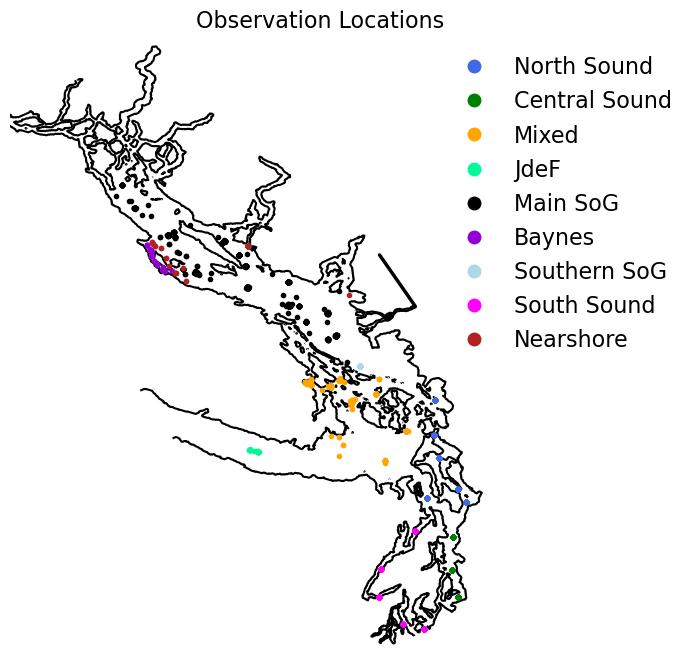

In [12]:
fig, ax = plt.subplots(1,1,figsize = (8,8))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('royalblue',
'green',
'orange',
'mediumspringgreen',
'black',
'darkviolet',
 'lightblue',
'fuchsia',
'firebrick','lime','darkgoldenrod','darkorange','deepskyblue','teal','darkgreen','darkblue','slateblue','purple')
datreg=dict()
for ind, iregion in enumerate(data.broadregions.unique()):
    datreg[iregion] = data.loc[data.broadregions==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 51)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(bbox_to_anchor=(1.1, 1),frameon=False,markerscale=3.)
ax.set_xlim(-126, -121);
ax.set_title('Observation Locations');
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False,markerscale=3.,fontsize=11)
ax.axis("off")
#fig.savefig('SalishSeaObservationLocations_noframe.jpg',bbox_inches='tight')

In [13]:
def byRegion(ax,obsvar,modvar,lims):
    SS=[]
    for ind, iregion in enumerate(data.broadregions.unique()):
        #ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                #color = colors[ind], label=iregion)
        SS0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                          cols=(colors[ind],),lname=iregion)
        SS.append(SS0)
    l=ax.legend(handles=[ip[0][0] for ip in SS])
    ax.set_xlabel('Log10 Observations (g C m$^{-2}$)+0.001')
    ax.set_ylabel('Log10 Model (g C m$^{-2}$)+0.001')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return SS,l

In [14]:
#data['Month']=[ii.month for ii in data['dtUTC']]
DJF=data.loc[(data.Month==12)|(data.Month==1)|(data.Month==2)]
MAM=data.loc[(data.Month==3)|(data.Month==4)|(data.Month==5)]
JJA=data.loc[(data.Month==6)|(data.Month==7)|(data.Month==8)]
SON=data.loc[(data.Month==9)|(data.Month==10)|(data.Month==11)]

In [15]:
def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    SS=et.varvarPlot(ax[0],DJF,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Winter')
    SS=et.varvarPlot(ax[1],MAM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Spring')
    SS=et.varvarPlot(ax[2],JJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('Summer')
    SS=et.varvarPlot(ax[3],SON,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Autumn')
    return 

In [16]:
data.region_name.unique()

array(['Whidbey Basin', 'Central Basin', 'Tidal Mixed', 'Juan de Fuca',
       'Northern Strait of Georgia', 'Central Strait of Georgia',
       'Baynes Sound', 'Gulf Islands', 'Southern Strait of Georgia',
       'Admiralty Inlet', 'Hood Canal', 'Nearshore-North East',
       'South Sound', 'Bellingham Bay', 'San Juan',
       'Nearshore North West', 'San Juan Islands',
       'Nearshore-Central East'], dtype=object)

In [17]:
#data.loc[(data.region_name=='Northern Strait of Georgia')|(data.region_name=='Central Strait of Georgia')|(data.region_name=='Southern Strait of Georgia'),['broadregions']]='SoG'
MainSoG=data.loc[(data.region_name=='Northern Strait of Georgia')|(data.region_name=='Central Strait of Georgia')]
SouthernSoG=data.loc[(data.region_name=='Southern Strait of Georgia')]
Nearshore=data.loc[(data.region_name=='Nearshore-Central East')|(data.region_name=='Nearshore-North East')|(data.region_name=='Nearshore North West')]
Baynes=data.loc[(data.region_name=='Baynes Sound')]
Mixed=data.loc[(data.region_name=='Tidal Mixed')|(data.region_name=='Gulf Islands')|(data.region_name=='San Juan Islands')|(data.region_name=='San Juan')]
JdeF=data.loc[(data.region_name=='Juan de Fuca')]

NorthSound=data.loc[(data.region_name=='Whidbey Basin')|(data.region_name=='Bellingham Bay')|(data.region_name=='Admiralty Inlet')]
CentralSound=data.loc[(data.region_name=='Central Basin')]
SouthSound=data.loc[(data.region_name=='South Sound')|(data.region_name=='Hood Canal')]
#data.loc[(data.region_name=='Hood Canal'),['broadregions']]='Hood Canal'

In [18]:
monthlymeanMainSoG=MainSoG.groupby(['Month']).mean()
monthlymeanSouthernSoG=SouthernSoG.groupby(['Month']).mean()
monthlymeanNearshore=Nearshore.groupby(['Month']).mean()
monthlymeanBaynes=Baynes.groupby(['Month']).mean()
monthlymeanMixed=Mixed.groupby(['Month']).mean()
monthlymeanJdeF=JdeF.groupby(['Month']).mean()
monthlymeanSouthSound=SouthSound.groupby(['Month']).mean()
monthlymeanNorthSound=NorthSound.groupby(['Month']).mean()
monthlymeanCentralSound=CentralSound.groupby(['Month']).mean()

monthlymean=data.groupby(['Month']).mean()

In [19]:
monthlysemMainSoG=MainSoG.groupby(['Month']).sem()
monthlysemSouthernSoG=SouthernSoG.groupby(['Month']).sem()
monthlysemNearshore=Nearshore.groupby(['Month']).sem()
monthlysemBaynes=Baynes.groupby(['Month']).sem()
monthlysemMixed=Mixed.groupby(['Month']).sem()
monthlysemJdeF=JdeF.groupby(['Month']).sem()
monthlysemSouthSound=SouthSound.groupby(['Month']).sem()
monthlysemNorthSound=NorthSound.groupby(['Month']).sem()
monthlysemCentralSound=CentralSound.groupby(['Month']).sem()

monthlysem=data.groupby(['Month']).sem()

/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:1510: RuntimeWarning: divide by zero encountered in true_divide
  result.iloc[:, cols].values / np.sqrt(self.count().iloc[:, cols]).values


In [20]:
print(monthlymean['Total'].mean())
print(monthlymean['mod_total'].mean()*5.7*12)

12.301316149010589
50.03850437051077


In [21]:
print(monthlymean['Total'].min())
print(monthlymean['mod_microzooplankton'].min()*5.7*12)

2.570378382176353
5.351237569828292


In [22]:
print(monthlymean['Total'].max())
print(monthlymean['mod_microzooplankton'].max()*5.7*12)

24.430377395121077
26.871699182816144


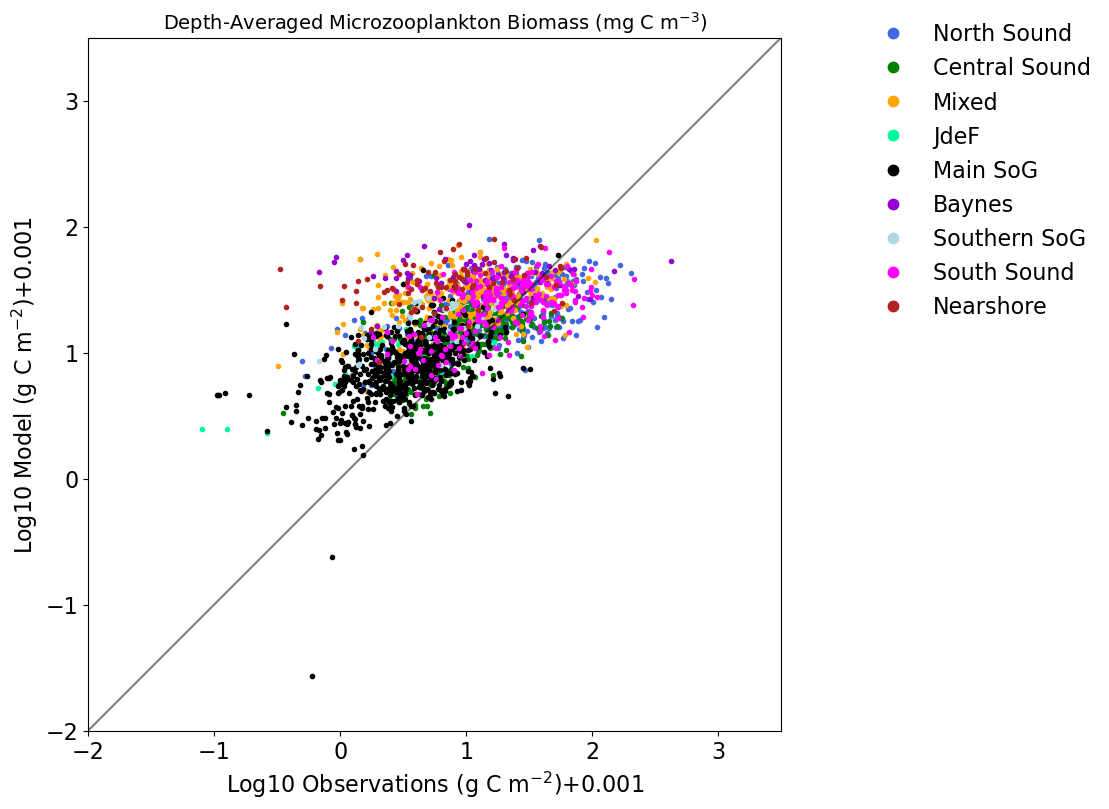

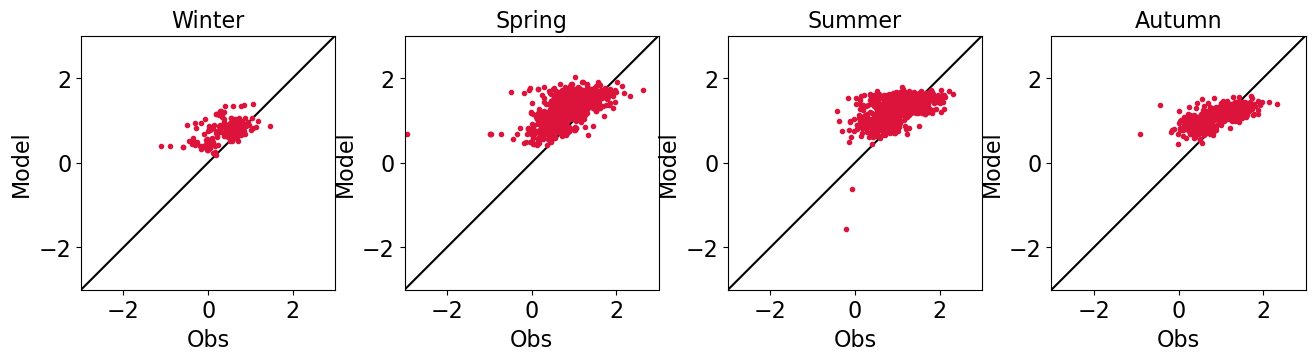

In [23]:
fig, ax = plt.subplots(1,1,figsize = (16,9))     
PS,l=byRegion(ax,'L10Total','L10mod_microzooplankton',(-2,3.5))
ax.set_title('Depth-Averaged Microzooplankton Biomass (mg C m$^{-3}$)',fontsize=14)
ax.legend(bbox_to_anchor=(1.1, 1.05),frameon=False,markerscale=2.5)
#fig.savefig('SalishSeaMicroZoopEval_byregion.jpg',bbox_inches='tight')
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Total','L10mod_microzooplankton',(-3,3))

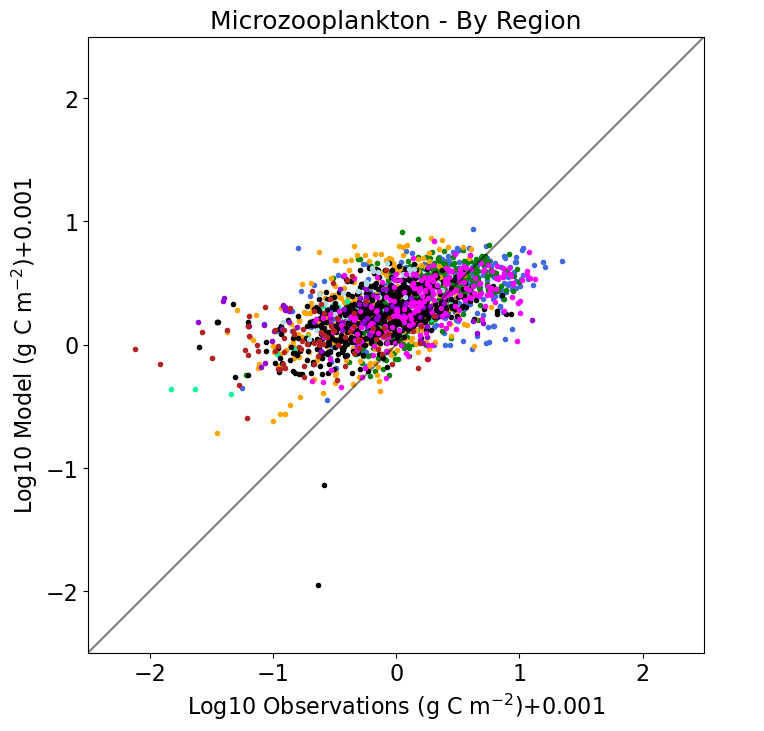

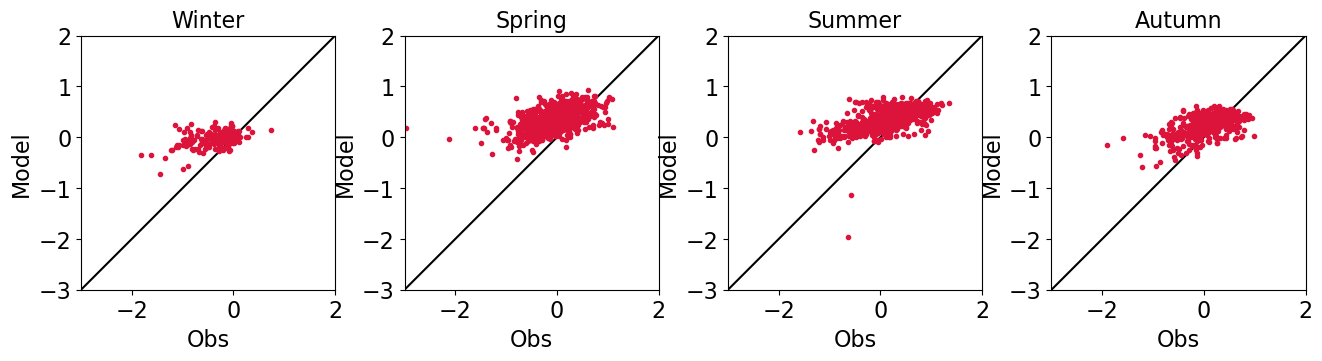

In [24]:
fig, ax = plt.subplots(1,1,figsize = (9,8))     
PS,l=byRegion(ax,'L10TotalDI','L10mod_microzooplanktonDI',(-2.5,2.5))
ax.set_title('Microzooplankton - By Region',fontsize=18)
ax.legend((),bbox_to_anchor=(1.1, 1.05),frameon=False,markerscale=2.5)
#fig.savefig('SalishSeaDIMicroZoopEval_byregion_noLegend.jpg',bbox_inches='tight')





fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10TotalDI','L10mod_microzooplanktonDI',(-3,2))



Text(1.5, -2.25, 'R$^{2}$ = 0.32')

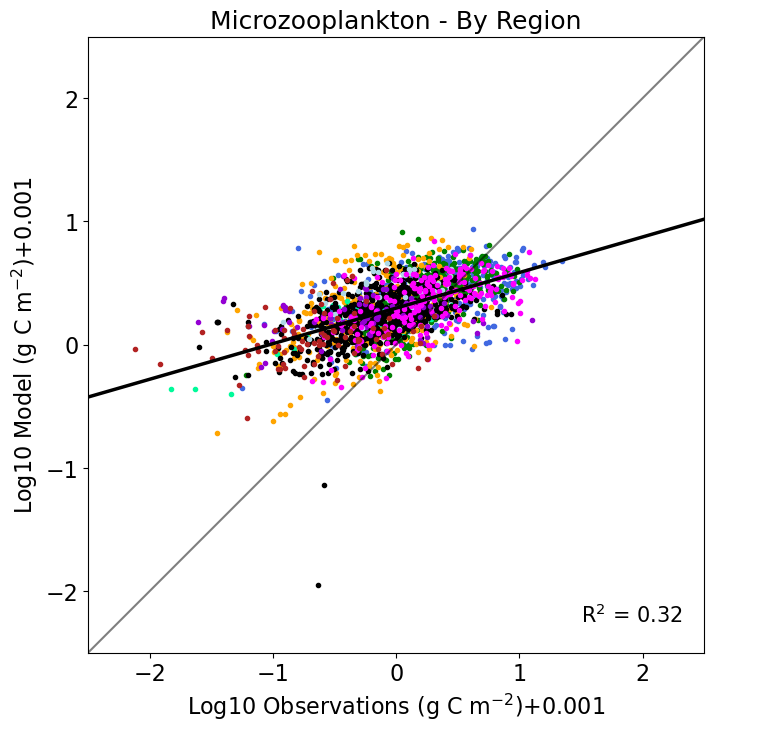

In [25]:
x=['L10TotalDI']
y=['L10mod_microzooplanktonDI']

#datatemp=datreg['South Sound']

iii=(~pd.isnull(data.L10TotalDI))&(~pd.isnull(data.L10mod_microzooplanktonDI))
x2=data.loc[iii,['L10TotalDI']].values[:,0]
y2=data.loc[iii,['L10mod_microzooplanktonDI']].values[:,0]

fig, ax = plt.subplots(1,1,figsize = (9,8))     
PS,l=byRegion(ax,x,y,(-2.5,2.5))
ax.set_title('Microzooplankton - By Region',fontsize=18)
ax.legend((),bbox_to_anchor=(1.1, 1.05),frameon=False,markerscale=2.5)


# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
a,b = np.polyfit(x2, y2, 1)

xseq=np.linspace(-2.5,2.5,10)

# Plot regression line
ax.plot(xseq, a * xseq + b , color="k", lw=2.5);
#ax.text(-2.25, 2, '(a)', fontsize=15,  color='k')
ax.text(1.5, -2.25, 'R$^{2}$ = 0.32', fontsize=15,  color='k')

#plt.savefig('SalishSeaDIMicroZoopEval_byregion_noLegend.png', bbox_inches='tight',dpi=1000,transparent=False)


In [26]:
b

0.29580681323860386

In [27]:
x_values=data['L10TotalDI']
y_values=data['L10mod_microzooplanktonDI']

iii=(~pd.isnull(data.L10TotalDI))&(~pd.isnull(data.L10mod_microzooplanktonDI))
x2_values=data.loc[iii,['L10TotalDI']].values[:,0]
y2_values=data.loc[iii,['L10mod_microzooplanktonDI']].values[:,0]

correlation_matrix = np.corrcoef(x2_values, y2_values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

0.3233963937825984


Text(1.5, -2.25, 'R$^{2}$ = 0.32')

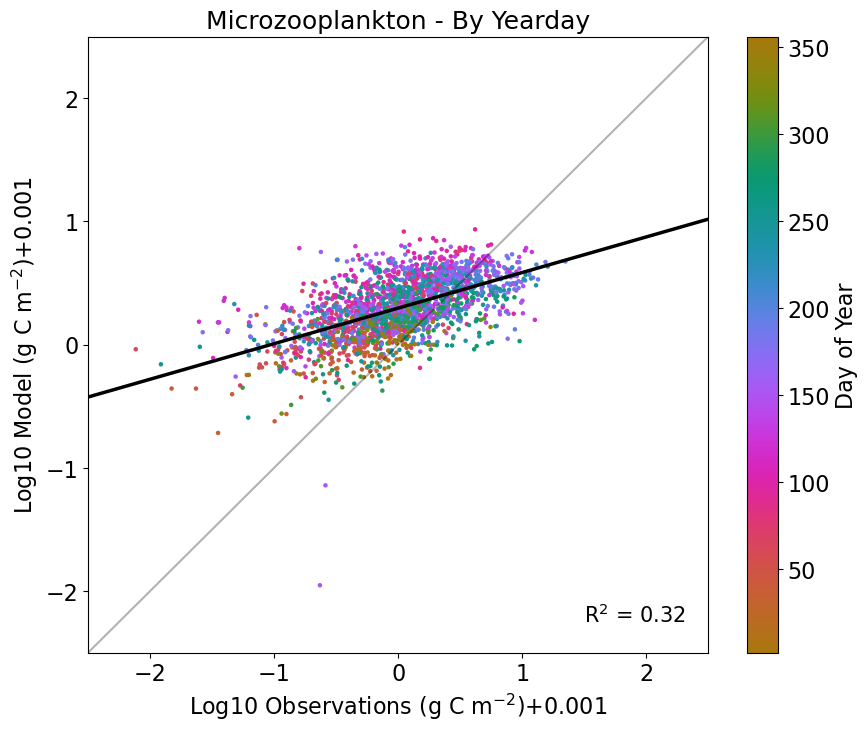

In [28]:
fig,ax=plt.subplots(1,1,figsize=(10,8))
m=ax.scatter((data['L10TotalDI']),((data['L10mod_microzooplanktonDI'])),
          c=data['YD'],s=5,cmap=cmocean.cm.phase)

ax.set_title('Microzooplankton - By Yearday',fontsize=18)
ax.set_xlabel('Log10 Observations (g C m$^{-2}$)+0.001', fontsize=16)
ax.set_ylabel('Log10 Model (g C m$^{-2}$)+0.001',fontsize=16)
ax.plot((-6,5),(-6,5),'k-',alpha=.3)
ax.set_xlim(-2.5,2.5)
ax.set_ylim(-2.5,2.5);
fig.colorbar(m,label='Day of Year')

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
a,b = np.polyfit(x2, y2, 1)

#xseq=np.linspace(-2.5,2.5,10)

# Plot regression line
ax.plot(xseq, a * xseq + b , color="k", lw=2.5);

#ax.text(-2.25, 2, '(b)', fontsize=15,  color='k')
ax.text(1.5, -2.25, 'R$^{2}$ = 0.32', fontsize=15,  color='k')

#fig.colorbar(m,label='Day of Year',fontsize=15)

#plt.savefig('SalishSeaDIMicrozoopModelvsObsbyDOY.png', bbox_inches='tight',dpi=1000,transparent=False)


In [29]:
x_values=data['L10TotalDI']
y_values=data['L10mod_microzooplanktonDI']

iii=(~pd.isnull(data.L10TotalDI))&(~pd.isnull(data.L10mod_microzooplanktonDI))
x2_values=data.loc[iii,['L10TotalDI']].values[:,0]
y2_values=data.loc[iii,['L10mod_microzooplanktonDI']].values[:,0]

correlation_matrix = np.corrcoef(x2_values, y2_values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

0.3233963937825984


In [30]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
  return np.log10(x+.001)

In [31]:
# define inverse log transform with same shift
def logt_inv(y):
    return 10**y-.001

In [32]:
data['Total']

0        0.493146
1        1.751657
2        3.584239
3        3.528410
4        3.108352
          ...    
2059    29.227748
2060     6.672926
2061     5.918648
2062    10.263113
2063     6.440243
Name: Total, Length: 2064, dtype: float64

In [33]:
data['logt_invL10Total']

0        0.493146
1        1.751657
2        3.584239
3        3.528410
4        3.108352
          ...    
2059    29.227748
2060     6.672926
2061     5.918648
2062    10.263113
2063     6.440243
Name: logt_invL10Total, Length: 2064, dtype: float64

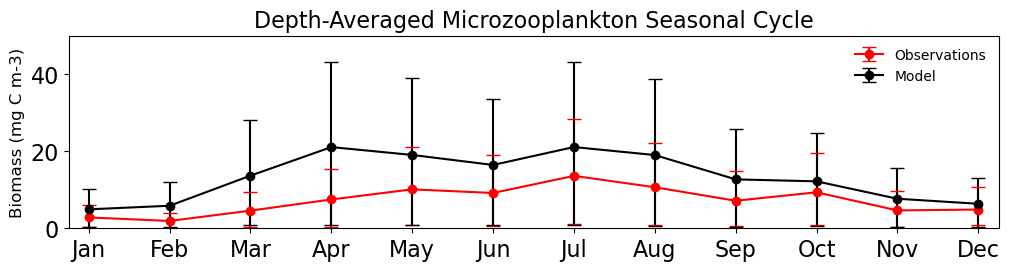

In [34]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named


#ax.plot(logt_inv(monthlymean['L10Total']),'--',color='k',label='Observations')
#ax.plot(logt_inv(monthlymean['L10mod_microzooplankton']),'--',color='blue',label='Model')
ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10Total'])),
               yerr=(np.array([logt_inv(monthlymean['L10Total']-monthlysem['L10Total']),
                 logt_inv(monthlymean['L10Total']+monthlysem['L10Total'])])),
              fmt='r-o',capsize=5,color='blue',label='Observations')

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10mod_microzooplankton'])),
               yerr=(np.array([logt_inv(monthlymean['L10mod_microzooplankton']-monthlysem['L10mod_microzooplankton']),
                 logt_inv(monthlymean['L10mod_microzooplankton']+monthlysem['L10mod_microzooplankton'])])),
              fmt='k-o',capsize=5,color='blue',label='Model')
ax.set_ylim(0,50)
ax.set_xlim(0.75,12.25)
ax.set_title('Depth-Averaged Microzooplankton Seasonal Cycle')
ax.set_ylabel('Biomass (mg C m-3)',fontsize=12)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.0))

Text(1, 4, '(a)')

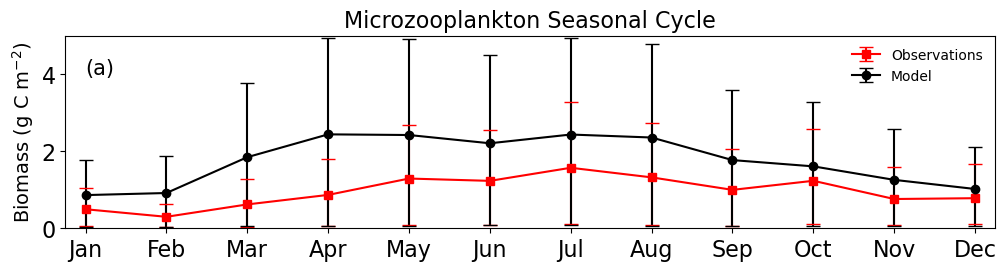

In [35]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named


#ax.plot(logt_inv(monthlymean['L10Total']),'--',color='k',label='Observations')
#ax.plot(logt_inv(monthlymean['L10mod_microzooplanktonDI']),'--',color='blue',label='Model')
ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10TotalDI'])),
               yerr=(np.array([logt_inv(monthlymean['L10TotalDI']-monthlysem['L10TotalDI']),
                 logt_inv(monthlymean['L10TotalDI']+monthlysem['L10TotalDI'])])),
              fmt='r',marker='s',capsize=5,color='blue',label='Observations')
ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10mod_microzooplanktonDI'])),
               yerr=(np.array([logt_inv(monthlymean['L10mod_microzooplanktonDI']-monthlysem['L10mod_microzooplanktonDI']),
                 logt_inv(monthlymean['L10mod_microzooplanktonDI']+monthlysem['L10mod_microzooplanktonDI'])])),
              fmt='k-o',capsize=5,color='blue',label='Model')
ax.set_ylim(0,5)
ax.set_xlim(0.75,12.25)
ax.set_title('Microzooplankton Seasonal Cycle')
ax.set_ylabel('Biomass (g C m$^{-2}$)',fontsize=14)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.0))
ax.text(1, 4, '(a)', fontsize=15,  color='k')

#plt.savefig('SalishSeaMicrozoopSeasonalCycle.png', bbox_inches='tight',dpi=1000,transparent=False)

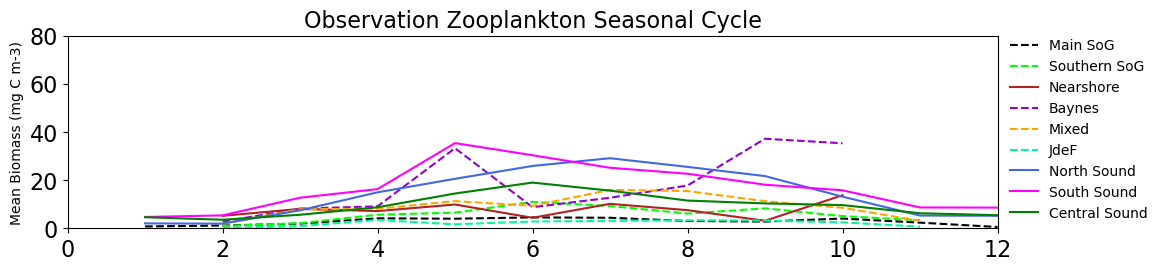

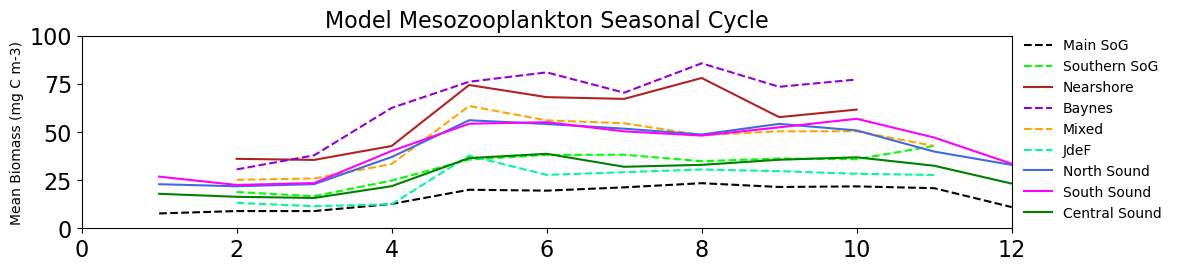

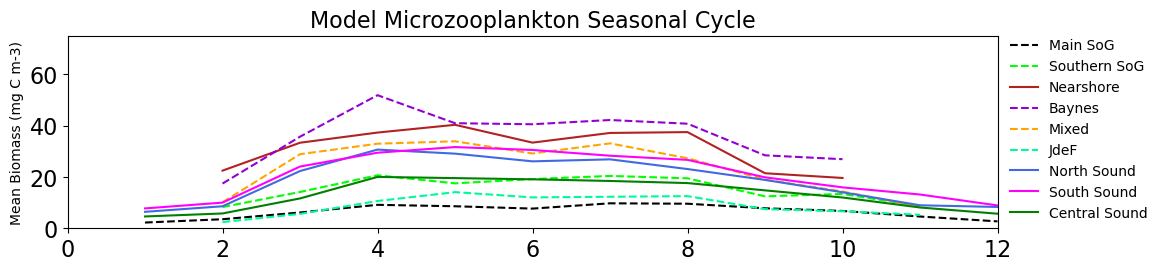

In [36]:
fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymeanMainSoG['L10Total']),'--',color='k',label='Main SoG')
ax.plot(logt_inv(monthlymeanSouthernSoG['L10Total']),'--',color='lime',label='Southern SoG')
ax.plot(logt_inv(monthlymeanNearshore['L10Total']),'-',color='firebrick',label='Nearshore')
ax.plot(logt_inv(monthlymeanBaynes['L10Total']),'--',color='darkviolet',label='Baynes')
ax.plot(logt_inv(monthlymeanMixed['L10Total']),'--',color='orange',label='Mixed')
ax.plot(logt_inv(monthlymeanJdeF['L10Total']),'--',color='mediumspringgreen',label='JdeF')
ax.plot(logt_inv(monthlymeanNorthSound['L10Total']),'-',color='royalblue',label='North Sound')
ax.plot(logt_inv(monthlymeanSouthSound['L10Total']),'-',color='fuchsia',label='South Sound')
ax.plot(logt_inv(monthlymeanCentralSound['L10Total']),'-',color='green',label='Central Sound')
ax.set_ylim(0,80)
ax.set_xlim(0,12)
ax.set_title('Observation Zooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg C m-3)',fontsize=10)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))

fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymeanMainSoG['L10mod_mesozooplankton']),'--',color='k',label='Main SoG')
ax.plot(logt_inv(monthlymeanSouthernSoG['L10mod_mesozooplankton']),'--',color='lime',label='Southern SoG')
ax.plot(logt_inv(monthlymeanNearshore['L10mod_mesozooplankton']),'-',color='firebrick',label='Nearshore')
ax.plot(logt_inv(monthlymeanBaynes['L10mod_mesozooplankton']),'--',color='darkviolet',label='Baynes')
ax.plot(logt_inv(monthlymeanMixed['L10mod_mesozooplankton']),'--',color='orange',label='Mixed')
ax.plot(logt_inv(monthlymeanJdeF['L10mod_mesozooplankton']),'--',color='mediumspringgreen',label='JdeF')
ax.plot(logt_inv(monthlymeanNorthSound['L10mod_mesozooplankton']),'-',color='royalblue',label='North Sound')
ax.plot(logt_inv(monthlymeanSouthSound['L10mod_mesozooplankton']),'-',color='fuchsia',label='South Sound')
ax.plot(logt_inv(monthlymeanCentralSound['L10mod_mesozooplankton']),'-',color='green',label='Central Sound')
ax.set_ylim(0,100)
ax.set_xlim(0,12)
ax.set_title('Model Mesozooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg C m-3)',fontsize=10)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))

fig,ax=plt.subplots(1,1,figsize=(12,2.5))
ax.plot(logt_inv(monthlymeanMainSoG['L10mod_microzooplankton']),'--',color='k',label='Main SoG')
ax.plot(logt_inv(monthlymeanSouthernSoG['L10mod_microzooplankton']),'--',color='lime',label='Southern SoG')
ax.plot(logt_inv(monthlymeanNearshore['L10mod_microzooplankton']),'-',color='firebrick',label='Nearshore')
ax.plot(logt_inv(monthlymeanBaynes['L10mod_microzooplankton']),'--',color='darkviolet',label='Baynes')
ax.plot(logt_inv(monthlymeanMixed['L10mod_microzooplankton']),'--',color='orange',label='Mixed')
ax.plot(logt_inv(monthlymeanJdeF['L10mod_microzooplankton']),'--',color='mediumspringgreen',label='JdeF')
ax.plot(logt_inv(monthlymeanNorthSound['L10mod_microzooplankton']),'-',color='royalblue',label='North Sound')
ax.plot(logt_inv(monthlymeanSouthSound['L10mod_microzooplankton']),'-',color='fuchsia',label='South Sound')
ax.plot(logt_inv(monthlymeanCentralSound['L10mod_microzooplankton']),'-',color='green',label='Central Sound')
ax.set_ylim(0,75)
ax.set_xlim(0,12)
ax.set_title('Model Microzooplankton Seasonal Cycle')
ax.set_ylabel('Mean Biomass (mg C m-3)',fontsize=10)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.05))


# 

In [37]:
    
datreg=dict()
for iregion in data.broadregions.unique():
    datreg[iregion] = data.loc[data.broadregions==iregion]  

In [38]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({
                      'All':data,
                      'Winter':DJF,
                      'Spring':MAM,
                      'Summer':JJA,
                      'Autumn': SON,})
for iregion in data.broadregions.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['All', 'Winter', 'Spring', 'Summer', 'Autumn', 'North Sound', 'Central Sound', 'Mixed', 'JdeF', 'Main SoG', 'Baynes', 'Southern SoG', 'South Sound', 'Nearshore'])

In [39]:
# Defining variables needed for mesozooplankton evaluations
obsvar='logt_invL10Total'
modvar='logt_invL10mod_microzooplankton'
year=2018 #how do I calculate for all years?

In [40]:
statsDict={year:dict()}
statsDict[year]['MicroZ']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['MicroZ'][isub]=dict()
    var=statsDict[year]['MicroZ'][isub]
    var['N'],var['mmean'],var['omean'],var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['MicroZ'],level='Subset',suborder=list(statsubs.keys()))
tbl

All
Winter
Spring
Summer
Autumn
North Sound
Central Sound
Mixed
JdeF
Main SoG
Baynes
Southern SoG
South Sound
Nearshore


In [41]:
# Defining variables needed for mesozooplankton evaluations
obsvar2='L10Total'
modvar2='L10mod_mesozooplankton'
year=2018 #how do I calculate for all years?

In [42]:
statsDict={year:dict()}
statsDict[year]['MicroZ']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['MicroZ'][isub]=dict()
    var=statsDict[year]['MicroZ'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar2]],
                                                                     statsubs[isub].loc[:,[modvar2]])
tbl,tdf=et.displayStats(statsDict[year]['MicroZ'],level='Subset',suborder=list(statsubs.keys()))
tbl

All
Winter
Spring
Summer
Autumn
North Sound
Central Sound
Mixed
JdeF
Main SoG
Baynes
Southern SoG
South Sound
Nearshore


In [43]:
# Defining variables needed for mesozooplankton evaluations
obsvar4='L10TotalDI'
modvar4='L10mod_microzooplanktonDI'
year=2018 #how do I calculate for all years?



In [44]:
statsDict={year:dict()}
statsDict[year]['MicroZ']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['MicroZ'][isub]=dict()
    var=statsDict[year]['MicroZ'][isub]
    var['N'],var['mmean'],var['omean'],var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar4]],
                                                                     statsubs[isub].loc[:,[modvar4]])
tbl,tdf=et.displayStats(statsDict[year]['MicroZ'],level='Subset',suborder=list(statsubs.keys()))
tbl

#tbl.to_excel("SalishSeaMicrozoopEvalStats.xlsx")

All
Winter
Spring
Summer
Autumn
North Sound
Central Sound
Mixed
JdeF
Main SoG
Baynes
Southern SoG
South Sound
Nearshore


In [45]:
# Defining variables needed for mesozooplankton evaluations
obsvar5='logt_invL10TotalDI'
modvar5='logt_invL10mod_microzooplanktonDI'
year=2018 #how do I calculate for all years?

In [46]:
statsDict={year:dict()}
statsDict[year]['MicroZ']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['MicroZ'][isub]=dict()
    var=statsDict[year]['MicroZ'][isub]
    var['N'],var['mmean'],var['omean'],var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar5]],
                                                                     statsubs[isub].loc[:,[modvar5]])
tbl,tdf=et.displayStats(statsDict[year]['MicroZ'],level='Subset',suborder=list(statsubs.keys()))
tbl

#tbl.to_excel("SalishSeaMicrozoopEvalStats_backtransformed.xlsx")

All
Winter
Spring
Summer
Autumn
North Sound
Central Sound
Mixed
JdeF
Main SoG
Baynes
Southern SoG
South Sound
Nearshore


In [47]:
data['L10mod_microzooplanktonDI']

0       0.164016
1       0.023628
2       0.078139
3      -0.109097
4      -0.147091
          ...   
2059    0.142731
2060    0.038750
2061    0.098143
2062   -0.002532
2063    0.118558
Name: L10mod_microzooplanktonDI, Length: 2064, dtype: float64

In [48]:
from sklearn.metrics import r2_score
x=data['L10TotalDI']
y=data['L10mod_microzooplanktonDI']


x=x[~np.isnan(x)]
y=y[~np.isnan(y)]
r_squared=r2_score(x,y)

print(r_squared)

-0.05712814967551538
